# Backend Documentation
Our backend codes can be found can be found in `../src/backend.ipynb`.

The goal of the backend analysis is to construct a pipeline that calculates the **connectivity score** for each of the 55 planning areas in Singapore. Connectivity is broken down into: 
1. **Availability**
- Number of train stations in the region
- Number of bus stops in the region
- Number of bus routes in the region
- Average frequency of buses (min) in each region (Frequency of Dispatch for Bus Services in the region)
 
2. **Accessibility**
- Differences in Travel Time (min) between taking Public and Private Transport (car) to:
  - CBD (Business)
  - ION Orchard (Leisure)
  - SGH (Healthcare)
- These three destinations are chosen because they represent three essential aspects of an ordinary resident's life. 

## How to use the scores
To use the constructed scores, simply load the files as shown below.

In [ ]:
import pandas as pd

avail_with_score = pd.read_csv('../data/avail_with_score.csv')
access_with_score = pd.read_csv('../data/access_score.csv')

#### Example Use Case: Top 10 Regions with Highest Overall Connectivity
We can combine both scores to analyse the overall connectivity of regions by taking a simple average of all metric scores.

In [ ]:
# merge both availability and accessibility scores
total_score = pd.merge(avail_with_score, access_with_score, on='planning_area', how='left', \
                       suffixes=('_avail', '_access'))
total_score['total_score'] = (total_score['total_score_avail'] + total_score['total_score_access']) / 2
total_score = total_score.sort_values(by='total_score', ascending=False).head(10)

We plot the Top 10 Regions with Highest Overall Connectivity below.

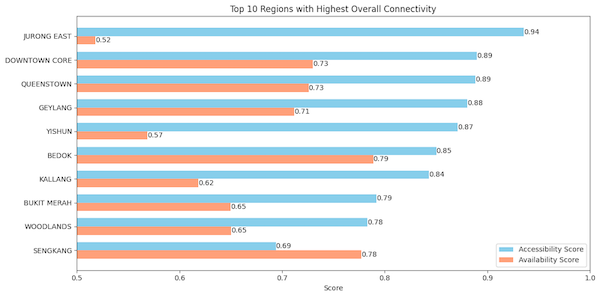

## Future Enhancements
More metrics can be easily added to the current score formulations. Potential metrics include difference in travel time to other important destinations and number of bus interchanges in the region. We can also allow user to customise the departure time for travel time data collection, as departure time is a self-defined parameter in our data collection function.
  
Connectivity scores can also be constructed and analysed on a subzone level instead of the current planning area level by extracting geospatial data on subzones. However, this data is currently not available from OneMap API, hence we were unable to map the bus stops and train stations to their respective subzones. 

## Data Collection


### Transport Services
We made API calls to [Singapore Land Transport Authority (LTA) DataMall](https://datamall.lta.gov.sg/content/datamall/en/dynamic-data.html) for data on:
- Bus Services: `../data/busservices.csv`
- Bus Routes: `../data/busroutes.csv`
- Bus Stops: `../data/busstops.csv`
- Passenger Volume by Bus Stops: `../data/pv.csv`

We downloaded the shapefile from LTA DataMall for data on:
- Train Stations: `../data/TrainStation_Feb2023/RapidTransitSystemStation.shp`

Note: `LTA_KEY` refers to your personal API Key from LTA DataMall.

#### Bus Services, Bus Routes, Bus Stops
We create a function for API calls to Bus Services, Bus Routes and Bus Stops where 
- `service_type`: refers to a string denoting Bus Services, Bus Routes or Bus Stops, to be included in the request URL
- `skip_values`: refers to a list containing number of records to skip for each request and depends on how large the dataset is as there is a limit of 500 records per request. 

In [ ]:
def get_pt_data(service_type, skip_values):
    base_url = "http://datamall2.mytransport.sg/ltaodataservice"
    
    service = []

    for skip in skip_values:
        endpoint_url = f"/{service_type}?$skip={skip}"
        resource_url = base_url + endpoint_url
        res = requests.get(resource_url, headers={"AccountKey": "LTA_KEY", "accept": "application/json"})
        res_list = res.json()
        df = pd.DataFrame(res_list['value'])
        service.append(df)

    service_df = pd.concat(service, ignore_index=True)
    return service_df

#### Passenger Volume by Bus Stops
This dataset had to be collected separately as additional parameters were required and the request returns a link to download the csv file instead. 

In [ ]:
import requests

# Passenger volume: produces link to download csv
base_url = "http://datamall2.mytransport.sg/ltaodataservice"
endpoint = "/PV/Bus"
resource_url = base_url + endpoint
last_3_months = ['202402', '202401', '202312']
for month in last_3_months:
    query_params = {'Date': month}
    # Request data from the server
    res = requests.get(resource_url, headers={"AccountKey": "LTA_KEY", "accept": "application/json"}, \
                       params=query_params)
    res_list = res.json()
    print(res_list['value'])

### Planning Areas
We made API calls to [OneMap API](https://www.onemap.gov.sg/apidocs/) to map each bus stop and train station to their respective planning areas using the location coordinates. \
We also downloaded the MasterPlan 2019 geojson file directly from [Data.gov.sg](https://beta.data.gov.sg/collections/2104/datasets/d_4765db0e87b9c86336792efe8a1f7a66/view) for the plotting of the boundaries on a heatmap.


#### From Data.gov.sg
We extract the Planning Area names from `Description` using regular expressions as it is rendered in HTML format. 

The final file to be used: `../data/planning_area.geojson`

In [ ]:
import geopandas as gpd
import re

planning_area = gpd.read_file('../data/MasterPlan2019PlanningAreaBoundaryNoSea.geojson')

pattern = r'<th>PLN_AREA_N</th>\s*<td>(.*?)</td>'

names = []
# Iterate through each row and apply regex pattern
for index, row in planning_area.iterrows():
    html_data = row['Description']
    result = re.search(pattern, html_data)
    if result:
        #print(result.group(1))
        names.append(result.group(1))
    else:
        print("Pattern not found.")

planning_area['planning_area'] = names
planning_area = planning_area[['planning_area', 'geometry']]
# save locally
planning_area.to_file('../data/planning_area.geojson', driver='GeoJSON')

#### Extract Planning Area from OneMap API to join with Bus Stops and Train Stations
The data can be found in: 
- Bus Stops: `../data/busstops_with_planningarea.csv`
- Train Stations: `../data/trainstations_with_planningarea.csv`

We create a function to loop through the data for Bus Stops and Train Stations with their coordinates to map to their planning areas where
- `pt_data`: refers to the dataframe for each public transport type, e.g. bus stops or train stations.

Notes: 
- The `token` specified is your token from OneMap API.
- The exact `query_string` required may change, refer to the OneMap API website for more information. 

In [ ]:
def get_planning_area(pt_data):
    pt_data['planning_area'] = ''

    domain = 'https://www.onemap.gov.sg/api/public/popapi/getPlanningarea?'
    token = 'xxx'
    headers = {"Authorization": token}
    incl_lat = 'latitude='
    incl_long = '&longitude='

    for index,row in pt_data.iterrows():
        
        if index % 100 == 0:
            print(index)
        
        lat = str(row['Latitude'])
        long = str(row['Longitude'])
        
        query_string = domain+incl_lat+lat+incl_long+long

        try:
            response = requests.request("GET", query_string, headers=headers, timeout=15)
            resp_list = response.json()

            pt_data.loc[index, "planning_area"] = resp_list[0]['pln_area_n']
            
        except:
            pt_data.loc[index, "planning_area"] = 'invalid'

    return pt_data

For train stations, we first convert the centroid coordinates in the shapefile to common latitude and longitude coordinates before running the loop to make API calls for the planning area of each train station.\
Note that you may need to swap the order in the `transform()` line in the future due to changes in the PyProj library.
- Example: `lon, lat = transform(wgs84, svy21, svy21_x, svy21_y)`

In [ ]:
import geopandas as gpd
from pyproj import Proj, transform

# Read the shapefile
shape = gpd.read_file("../data/TrainStation_Feb2023/RapidTransitSystemStation.shp")

# Calculate centroid coordinates
shape['centroid_y'] = shape.geometry.centroid.y
shape['centroid_x'] = shape.geometry.centroid.x

# Define the SVY21 projection (EPSG:3414)
svy21 = Proj(init='EPSG:3414')

# Define the WGS84 projection (EPSG:4326)
wgs84 = Proj(init='EPSG:4326')

# Define the SVY21 coordinates (example values)
svy21_x = shape['centroid_x']
svy21_y = shape['centroid_y']

# Perform the coordinate transformation
lon, lat = transform(svy21, wgs84, svy21_x, svy21_y)

# Append the latitude and longitude coordinates to the dataframe
location = pd.DataFrame({'latitude': lat, 'longitude': lon})
trainstations = pd.concat([shape, location], axis=1)

### Travel Time
We made API calls to [Google Maps Platform](https://developers.google.com/maps) for data on travel time by `transit` (public mode) or `driving` (private mode) from each of the 55 residential areas in Singapore to the three destination of interests: CBD area, ION Orchard and Singapore General Hospital, with departure time set to the Monday 5pm. 

Note:
- `GMAP_KEY` refers to your personal API Key from Google Maps Platform.
- `unix_timestamp` refers to the timestamp for the nearest Monday 5pm, singapore time, from the time of data collection.

The data are stored in the following files:
- Public Transport Travel Times: `../data/travel_data_public.csv`
- Private Transport Travel Times: `../data/travel_data_private.csv`

From our exploratory data analysis using Passenger Volume by Bus Stops, we find that the Highest Average Volume is during a weekday at 7-8am and 5-6pm likely due to people commuting to and fro work. Hence, we chose a Monday (weekday) 5pm to better represent public transport commuters' demand. 

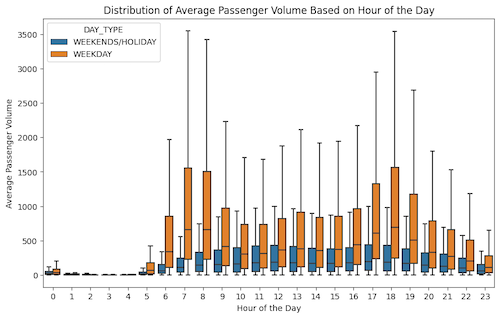

In [ ]:
import datetime
import pytz

def get_next_weekday(start_date, weekday, time, timezone_str):
    """
    Get the next specific weekday and time in the specified timezone.

    :param start_date: datetime.date, the date from which to find the next weekday
    :param weekday: int, desired weekday (0=Monday, 6=Sunday)
    :param time: datetime.time, desired time on the given weekday
    :param timezone_str: str, the string representing the timezone
    :return: datetime.datetime, the next weekday occurrence at the given time
    """
    timezone = pytz.timezone(timezone_str)
    current_datetime = datetime.datetime.combine(start_date, time)
    current_datetime = timezone.localize(current_datetime)

    # Increment date until we hit the desired weekday
    while current_datetime.weekday() != weekday:
        current_datetime += datetime.timedelta(days=1)

    return current_datetime

# Define parameters
desired_weekday = 0  # Monday
desired_time = datetime.time(17, 0)  # 5 PM
local_timezone = 'Asia/Singapore'  # Change as per your location

# Get today's date
today = datetime.date.today()
next_monday_at_5pm = get_next_weekday(today, desired_weekday, desired_time, local_timezone)

# Convert to Unix timestamp
unix_timestamp = int(next_monday_at_5pm.timestamp())
print("The Unix timestamp for the next Monday at 5 PM is:", unix_timestamp)

In [ ]:
def get_travel_time(origin, destination, api_key, mode):
    endpoint_url = "https://maps.googleapis.com/maps/api/directions/json"
    
    # Parameters
    params = {
        'origin': origin,
        'destination': destination,
        'mode': mode,
        'key': api_key,
        'departure_time': unix_timestamp
    }
    
    # Make a GET request to the Google Maps API
    response = requests.get(endpoint_url, params=params)
    data = response.json()
    
    # Check if the request was successful
    if data['status'] == 'OK':
        # Extract travel time
        route = data['routes'][0]
        leg = route['legs'][0]
        duration = leg['duration']
        return round(duration['value']/60) # travel time in minutes
    else:
        return "Error: " + data['status']

In [ ]:
# Get all 55 residential areas
planning_area_data = gpd.read_file('../data/planning_area.geojson')
planning_area_names = planning_area_data['planning_area']

# Define three target destinations of interest
destinations = {'ION': 'ION ORCHARD, SINGAPORE', 
                'SGH': 'SINGAPORE GENERAL HOSPITAL, SINGAPORE', 
                'CBD': 'CITY HALL MRT STATION, SINGAPORE'}

In [ ]:
def save_travel_time():
    # dataframe to store travel times
    df1 = [] # public
    df2 = [] # private
    modes = ['transit', 'driving']

    for mode in modes:
        for origin in planning_area_names:
            for dest in destinations:
                ori = origin + ', SINGAPORE'
                travel_time = get_travel_time(ori, destinations[dest], GMAP_KEY, mode)
                if mode == 'transit': 
                    df1.append([origin, dest, travel_time])
                else: 
                    df2.append([origin, dest, travel_time])
    travel_data_public = pd.DataFrame(df1, columns=['planning_area', 'destination', 'time_public'])
    travel_data_private = pd.DataFrame(df2, columns=['planning_area', 'destination', 'time_private'])
    
    # save locally
    travel_data_public.to_csv("../data/travel_data_public.csv", index=False)
    travel_data_private.to_csv("../data/travel_data_private.csv", index=False)

### Resident Population in 2023
We retrieved resident population data from [SingStat](https://www.singstat.gov.sg/find-data/search-by-theme/population/population-and-population-structure/latest-data) since population density in an area can be a key factor for commuters in deciding whether to move to an area. 

To make the data more interpretable for users in the dashboard, we cleaned the data using the below steps: 
1. Categorise the population into 3 age groups: 0-20 years, 21-64 years and 65 years and above.
2. Summarise population based on age groups and region using `GROUPBY`.

The cleaned data can be found in: `../data/pop_by_agegroup.csv`

## Construction of Connectivity Scores

Here we consider two aspects of connectivity of a residential area, availability (of public transport services) and accessibility (by taking public services). Below are formulaic represeations of the two scores.

### Availability Score

$$
\text{availability score} = w_1 \times \text{num busstops score} + w_2 \times \text{num trainstations score} + \\
w_3 \times \text{num busservices score} + w_4 \times \text{avg bus freq score}
$$
$$ \text{where } w_i \text{ are weights to be assigned by the user in the interface and } {\sum_{i=1}^{4} w_i} = 1
$$

### Accessibility Score

$$
\text{accessibility score} = w_1 \times \text{cbd diff score} + w_2 \times \text{ion diff score} + w_3 \times \text{sgh diff score} 
$$
$$ \text{where } w_i \text{ are weights to be assigned by the user in the interface and } {\sum_{i=1}^{3} w_i} = 1
$$

We use a weighted average of all the metrics in each category, where the coefficients can be customised by the commuters so long as they add up to 1. In this way, the final scores are dynamic and more representative of the user’s personal preferences. 

For example, a user who only cares about going to the CBD may assign a weight of 1 to `cbd diff score` and 0 for the rest when looking at accessibility. 

### Availability Score
The final scores can be found here: `../data/avail_with_score.csv`.

For all the metrics defined in our Availability Score, we summarised the data from LTA DataMall for each region using a `GROUPBY` clause.\
Below is an example using Bus Stops data (`busstops`) for **Number of Bus Stops** in the region:

In [ ]:
num_busstops = busstops.groupby('planning_area').size().reset_index(name='num_busstops')

#### Number of Bus Routes in each Region
Using Bus Routes data (`busroutes`), we perform an additional join with the `busstops` data to map the planning areas to each bus service (route) and extract the unique records before summarising the data for each region. 

In [13]:
busroutes_planning_area = busroutes.merge(busstops, left_on='BusStopCode', right_on='BusStopCode', how='left')
busroutes_planningarea = busroutes_planning_area[['ServiceNo', 'planning_area']].drop_duplicates()

#### Average Frequency of Bus Services in each Region
Using Bus Services data, we perform another join with the `busroutes_planning_area` data to map the bus frequencies of each service to their respective planning areas.\
Next, we further cleaned the data of the frequency columns before calculating the average of the frequencies. 

### Accessibility Score
The final scores can be found here: `../data/access_score.csv`.

#### Difference in Travel Time (min) between taking Public and Private Transport
The difference in travel time to each destination is defined by Public Transport Travel Time (`time_public`) - Private Transport Travel Time (`time_private`) from the Travel Time datasets.

Note that we do not simply take the public transport time as it could just result in downtown areas having shorter time and higher accessibility. Thus, the difference between public and private would be more indicative of how accessible a region is by only taking public transport, especially for commuters who are exploring heartland regions when looking to purchase/rent a new home.

### Data Normalisation
To construct the final availability and accessibility scores, we performed Min-Max Scaling to scale all metrics into [0,1] to make them comparable. Noting that some metrics like **Average Bus Frequency** are negatively correlated with the connectivity score (e.g. a lower Average Bus Frequency means higher availability), we reversed the direction of these metrics before scaling to ensure that all metrics are positively correlated with the final score. 

Below is an example using `availability` to construct **Availability Score**:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# Apply Min-Max scaling to normalize values to positive numbers only
avail_values = availability.drop(columns='planning_area')

# Reverse direction of Freq columns
avail_values['avg_bus_freq'] = - avail_values['avg_bus_freq']

# Shift values by their minimum value to make them positive
avail_values = avail_values - avail_values.min()

# Apply Min-Max scaling to scale values to the range [0, 1]
avail_values = pd.DataFrame(min_max_scaler.fit_transform(avail_values), columns=avail_values.columns)

# Add the avail_values columns back to the DataFrame
avail_values = avail_values.add_suffix('_score')
avail_with_score = pd.concat([availability, avail_values], axis=1)